In [1]:
import tensorflow as tf
import pathlib
import pandas as pd
import os
import io
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding="ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")

In [5]:
df["v2_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["v2_clean"] = df["v2_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["v2_clean"] = df["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df.head()


,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [6]:
mask = df["v2_clean"].apply(lambda x: type(x)==str)
mask.value_counts()
df = df.loc[mask,:]

In [7]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words =1000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df["v2_clean"])
df["v2_encoded"] = tokenizer.texts_to_sequences(df["v2_clean"])
df.head()

,v1,v2,v2_clean,v2_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 465, 289, 2, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 150, 1, 2, 79]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[705, 20, 663, 129]"


In [8]:
df["v1"] = df["v1"].apply(lambda x: 0 if x =='ham' else 1)
df.head()

,v1,v2,v2_clean,v2_encoded
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 465, 289, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 150, 1, 2, 79]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[705, 20, 663, 129]"


In [9]:
v2_pad = tf.keras.preprocessing.sequence.pad_sequences(df["v2_encoded"], padding="post")

In [10]:
x_train, x_val, y_train, y_val = train_test_split(v2_pad, df["v1"], test_size=0.2)

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [11]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[v2_pad.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 8)             8008      
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8169 (31.91 KB)
Trainable params: 8169 (31.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [14]:
# Model training
history = model.fit(train_batch,
          epochs=50,
          validation_data=val_batch)

Epoch 1/50
70/70 [==============================] - 2s 6ms/step - loss: 0.6633 - binary_accuracy: 0.8028 - val_loss: 0.6149 - val_binary_accuracy: 0.8574
Epoch 2/50
70/70 [==============================] - 0s 3ms/step - loss: 0.5205 - binary_accuracy: 0.8681 - val_loss: 0.4405 - val_binary_accuracy: 0.8574
Epoch 3/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3861 - binary_accuracy: 0.8681 - val_loss: 0.3801 - val_binary_accuracy: 0.8574
Epoch 4/50
70/70 [==============================] - 0s 4ms/step - loss: 0.3549 - binary_accuracy: 0.8681 - val_loss: 0.3673 - val_binary_accuracy: 0.8574
Epoch 5/50
70/70 [==============================] - 0s 4ms/step - loss: 0.3422 - binary_accuracy: 0.8681 - val_loss: 0.3531 - val_binary_accuracy: 0.8574
Epoch 6/50
70/70 [==============================] - 0s 4ms/step - loss: 0.3278 - binary_accuracy: 0.8681 - val_loss: 0.3365 - val_binary_accuracy: 0.8574
Epoch 7/50
70/70 [==============================] - 0s 3ms/step - loss: 0.30

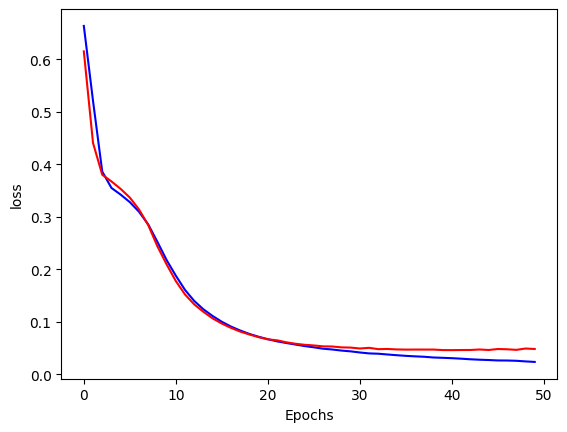

In [15]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

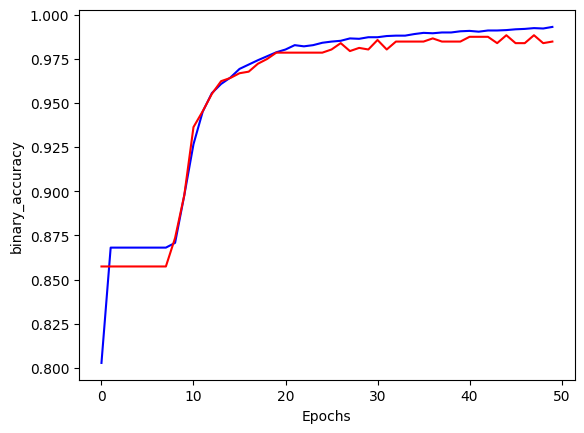

In [16]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.show()

In [17]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

model_simple = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[v2_pad.shape[1],],name="embedding"),
                  SimpleRNN(units=64, return_sequences=False),
                  Dense(1, activation="sigmoid")
])

In [18]:
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            64064     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 72385 (282.75 KB)
Trainable params: 72385 (282.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
optimizer= tf.keras.optimizers.Adam()

model_simple.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [20]:
# Model training
history = model_simple.fit(train_batch,
          epochs=30,
          validation_data=val_batch)

Epoch 1/30
70/70 [==============================] - 4s 31ms/step - loss: 0.4109 - binary_accuracy: 0.8591 - val_loss: 0.4130 - val_binary_accuracy: 0.8574
Epoch 2/30
70/70 [==============================] - 2s 26ms/step - loss: 0.3907 - binary_accuracy: 0.8681 - val_loss: 0.4097 - val_binary_accuracy: 0.8574
Epoch 3/30
70/70 [==============================] - 3s 39ms/step - loss: 0.3909 - binary_accuracy: 0.8681 - val_loss: 0.4097 - val_binary_accuracy: 0.8574
Epoch 4/30
70/70 [==============================] - 2s 25ms/step - loss: 0.3911 - binary_accuracy: 0.8681 - val_loss: 0.4097 - val_binary_accuracy: 0.8574
Epoch 5/30
70/70 [==============================] - 2s 27ms/step - loss: 0.3916 - binary_accuracy: 0.8681 - val_loss: 0.4097 - val_binary_accuracy: 0.8574
Epoch 6/30
70/70 [==============================] - 2s 27ms/step - loss: 0.3908 - binary_accuracy: 0.8681 - val_loss: 0.4122 - val_binary_accuracy: 0.8574
Epoch 7/30
70/70 [==============================] - 2s 28ms/step - los

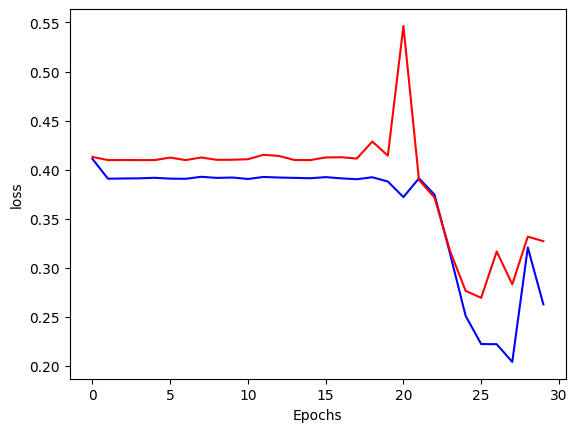

In [21]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

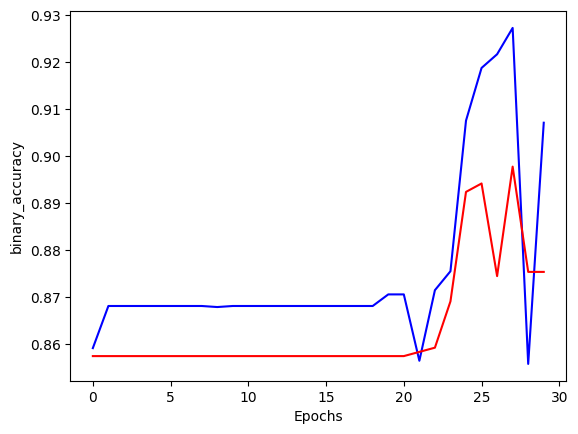

In [22]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.show()

In [23]:
model_gru_reg = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[v2_pad.shape[1],],name="embedding"),
                  GRU(units=32, return_sequences=False),
                  Dense(1, activation="sigmoid")
])

In [24]:
optimizer= tf.keras.optimizers.Adam()

model_gru_reg.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [25]:
history = model_gru_reg.fit(train_batch,
              epochs=30,
              validation_data=val_batch)

Epoch 1/30
70/70 [==============================] - 8s 61ms/step - loss: 0.4485 - binary_accuracy: 0.8681 - val_loss: 0.4097 - val_binary_accuracy: 0.8574
Epoch 2/30
70/70 [==============================] - 3s 44ms/step - loss: 0.3913 - binary_accuracy: 0.8681 - val_loss: 0.4098 - val_binary_accuracy: 0.8574
Epoch 3/30
70/70 [==============================] - 4s 60ms/step - loss: 0.3910 - binary_accuracy: 0.8681 - val_loss: 0.4104 - val_binary_accuracy: 0.8574
Epoch 4/30
70/70 [==============================] - 3s 48ms/step - loss: 0.3914 - binary_accuracy: 0.8681 - val_loss: 0.4098 - val_binary_accuracy: 0.8574
Epoch 5/30
70/70 [==============================] - 3s 45ms/step - loss: 0.3910 - binary_accuracy: 0.8681 - val_loss: 0.4097 - val_binary_accuracy: 0.8574
Epoch 6/30
70/70 [==============================] - 3s 44ms/step - loss: 0.3902 - binary_accuracy: 0.8681 - val_loss: 0.4101 - val_binary_accuracy: 0.8574
Epoch 7/30
70/70 [==============================] - 5s 67ms/step - los

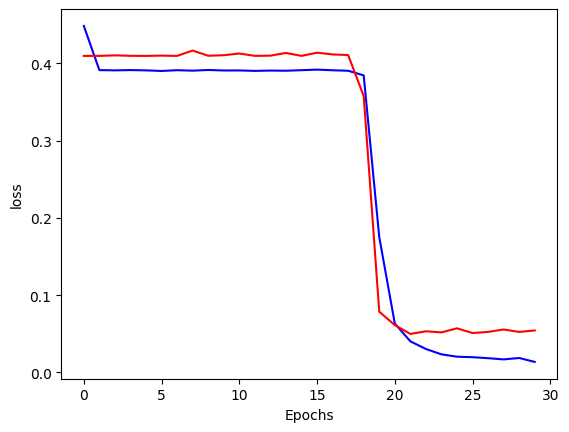

In [26]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

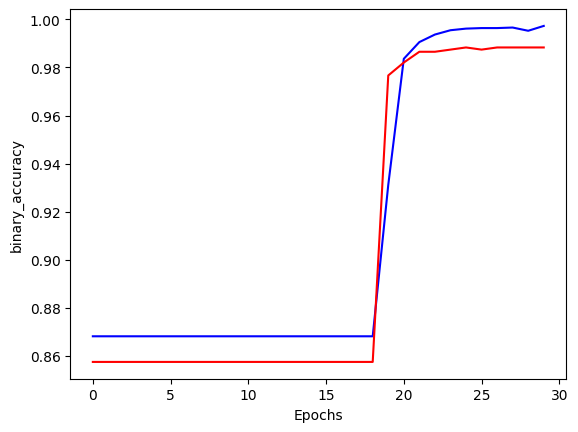

In [27]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.show()